# Practical

## Background

Social platforms face a constant stream of user-generated text, some of which can be misleading or outright fake news. To support trust & safety workflows, this project builds an end-to-end NLP pipeline that explores language patterns (POS/NER), normalizes text, analyzes sentiment and topics, and then classifies whether an article is Fake or Factual. The working dataset contains 198 English-language articles with a balanced fake_or_factual label.

## Import Data

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

In [81]:
# set plot options
plt.rcParams['figure.figsize'] = (12, 8)
default_plot_colour = "#00bfbf"

In [82]:
data = pd.read_csv("fake_news_data.csv")

In [83]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


The dataset contains the title of a news article, the text within the news article, the publication date, and a tag indicating whether the article is fake news or factual news.

In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


It contains 198 entries, meaning 198 rows, and there are no null values. Therefore, we do not need to handle missing data before proceeding with comparisons between fake and factual news articles.

Text(0.5, 1.0, 'Count of Article Classification')

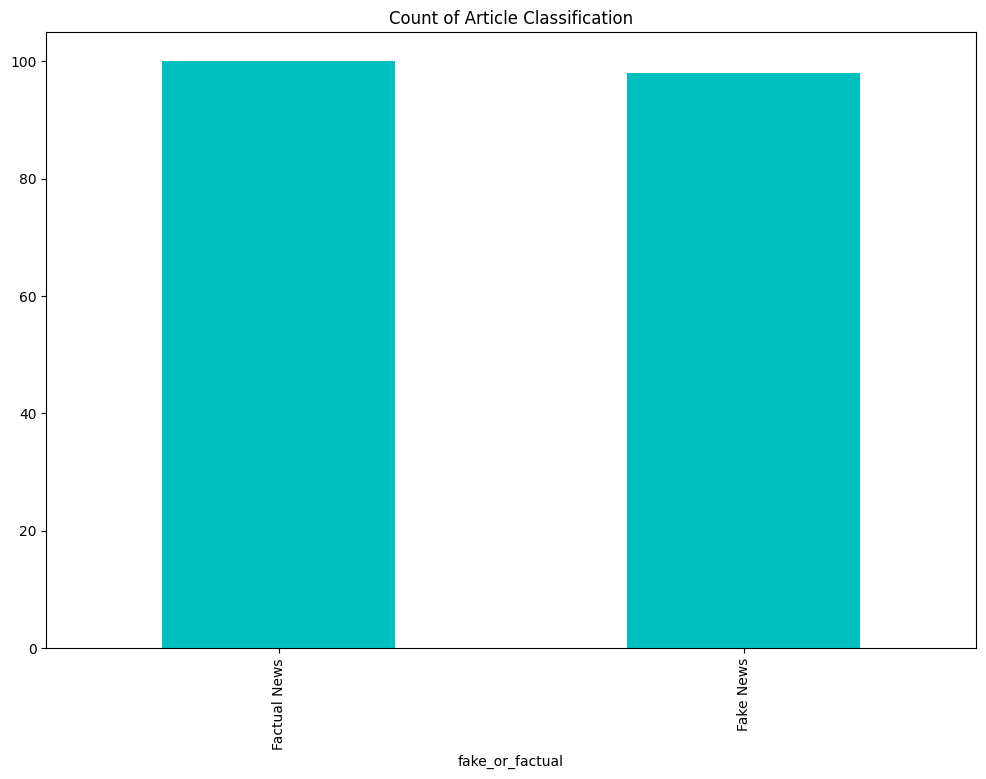

In [85]:
data['fake_or_factual'].value_counts().plot(kind='bar', color=default_plot_colour)
plt.title('Count of Article Classification')

The chart shows that we have equal numbers of fake and factual news articles, which is ideal for our analysis. If there were significantly different numbers of rows in each group, we would need to take steps to balance the dataset. In our case, we can proceed with the analysis.

## Import packages required for processing and analysis

In [86]:
import seaborn as sns
import spacy
from spacy import displacy
from spacy import tokenizer
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel, TfidfModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

## POS Tagging

we need to initialize our SpaCy model and specifying the model we want to use.

In [87]:
nlp = spacy.load('en_core_web_sm')

We will separate the data into fake news and factual news subsets to compare the POS tags occurring in each. We create our fake news dataset by filtering the dataframe where the column fake_or_factual equals "fake news". Similarly, we create the factual news dataset by filtering the dataframe where fake_or_factual equals "factual news".

In [88]:
# split data by fake and factual news
fake_news = data[data['fake_or_factual'] == "Fake News"]
fact_news = data[data['fake_or_factual'] == "Factual News"]

Next, we create two separate SpaCy documents for each subset. For the fake news dataset, we use nlp.pipe() over the text column and convert the result to a list. We repeat the same process for the factual news dataset, creating a list of SpaCy documents using nlp.pipe() over the factual news text.

In [89]:
# create spacey documents - use pipe for dataframe
fake_spacydocs = list(nlp.pipe(fake_news['text']))
fact_spacydocs = list(nlp.pipe(fact_news['text']))

Then we define a function extract_token_tags that takes a SpaCy document as input and returns the token text, named entity type, and POS tag for each token in the document. This function extracts not only the POS tags but also the entity types for named entity recognition, which will be explored later.

In [90]:
# create function to extract tags for each document in our data
def extract_token_tags(doc:spacy.tokens.doc.Doc):
    return [(i.text, i.ent_type_, i.pos_) for i in doc] 

We iterate through each SpaCy document in the fake news dataset, extract the relevant tags using extract_token_tags, convert the results into a dataframe with the specified columns, and append it to fake_tags_df. After processing all documents, we concatenate the list of dataframes into a single dataframe assigned back to fake_tags_df.

In [91]:
# tag fake dataset
fake_tagsdf = []
columns = ["token", "ner_tag", "pos_tag"]

In [92]:
for ix, doc in enumerate(fake_spacydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fake_tagsdf.append(tags)

In [93]:
fake_tagsdf = pd.concat(fake_tagsdf)

We repeat the exact same process for the factual news dataset, creating fact_tags_df by copying the code and switching the dataset accordingly.

In [94]:
# tag factual dataset 
fact_tagsdf = []

for ix, doc in enumerate(fact_spacydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fact_tagsdf.append(tags)

In [95]:
fact_tagsdf = pd.concat(fact_tagsdf)

In [96]:
fake_tagsdf.head()

,token,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN


In [97]:
# token frequency count (fake)
pos_counts_fake = fake_tagsdf.groupby(["token", "pos_tag"]).size().reset_index(name="counts").sort_values(by="counts", ascending=False)
pos_counts_fake.head(10)

,token,pos_tag,counts
29,",",PUNCT,1908
7451,the,DET,1834
41,.,PUNCT,1530
5766,of,ADP,922
2665,and,CCONJ,875
2449,a,DET,805
0,,SPACE,795
7528,to,PART,767
4921,in,ADP,668
5099,is,AUX,419


This shows the most frequently occurring tokens along with their associated POS tags and counts. We repeat the token frequency count for the factual news dataset by applying the same grouping, counting, sorting, and displaying steps.

In [98]:
# token frequency count (fact)
pos_counts_fact = fact_tagsdf.groupby(["token", "pos_tag"]).size().reset_index(name="counts").sort_values(by="counts", ascending=False)
pos_counts_fact.head(10)

,token,pos_tag,counts
6145,the,DET,1903
14,",",PUNCT,1698
21,.,PUNCT,1382
4716,of,ADP,884
1898,a,DET,789
2093,and,CCONJ,757
4005,in,ADP,671
6205,to,PART,660
4743,on,ADP,482
5567,said,VERB,451


In [99]:
# frequencies of pos tags in fake
pos_counts_fake.groupby('pos_tag')['token'].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     2586
VERB     1817
PROPN    1672
ADJ       882
ADV       413
NUM       221
PRON       96
ADP        89
AUX        62
SCONJ      51
Name: token, dtype: int64

The results show that nouns have the most unique values, followed by verbs and proper nouns in the fake news dataset.

In [100]:
# frequencies of pos tags in fact
pos_counts_fact.groupby('pos_tag')['token'].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     2179
VERB     1539
PROPN    1379
ADJ       747
ADV       263
NUM       205
PRON       79
ADP        70
AUX        43
SCONJ      42
Name: token, dtype: int64

In [101]:
# dive into diferences in nouns
pos_counts_fake[pos_counts_fake.pos_tag == "NOUN"][:15]

,token,pos_tag,counts
5981,people,NOUN,77
7349,t,NOUN,65
6216,president,NOUN,58
7960,women,NOUN,55
7516,time,NOUN,52
3138,campaign,NOUN,44
8011,year,NOUN,44
4581,government,NOUN,41
5213,law,NOUN,40
8013,years,NOUN,40


The most popular nouns in the fake news dataset include words like "people", "president", "women", "time", "campaign" and "year". We then examine the top nouns in the factual news dataset.

In [102]:
pos_counts_fact[pos_counts_fact.pos_tag == "NOUN"][:15]

,token,pos_tag,counts
3738,government,NOUN,71
6618,year,NOUN,64
5901,state,NOUN,57
2360,bill,NOUN,55
1975,administration,NOUN,51
5066,president,NOUN,49
3277,election,NOUN,48
4919,people,NOUN,45
4786,order,NOUN,45
4259,law,NOUN,42


Although nouns are common in both datasets, the specific words and their frequency rankings differ considerably. For example, "government" is the top noun in the factual dataset but ranks much lower in the fake news dataset. Other nouns like "bill", "administration", and "election" appear prominently in the factual news but less so in fake news.

This comparison reveals that while POS tag frequencies may be similar, the actual words within each category can differ significantly between fake and factual news.

## Named Entities

In [103]:
top_entities_fake = fake_tagsdf[fake_tagsdf['ner_tag'] != ""].groupby(['token', 'ner_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)

In [104]:
top_entities_fact = fact_tagsdf[fact_tagsdf['ner_tag'] !=  ""].groupby(['token', 'ner_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)

In [105]:
ner_pallete = {
    'ORG': sns.color_palette("Set2").as_hex()[0],
    'GPE': sns.color_palette("Set2").as_hex()[1],
    'NORP': sns.color_palette("Set2").as_hex()[2],
    'PERSON': sns.color_palette("Set2").as_hex()[3],
    'DATE': sns.color_palette("Set2").as_hex()[4],
    'CARDINAL': sns.color_palette("Set2").as_hex()[5],
    'PERCENT': sns.color_palette("Set2").as_hex()[6]
}

[Text(0.5, 1.0, 'Most Common Named Entities in Fake News')]

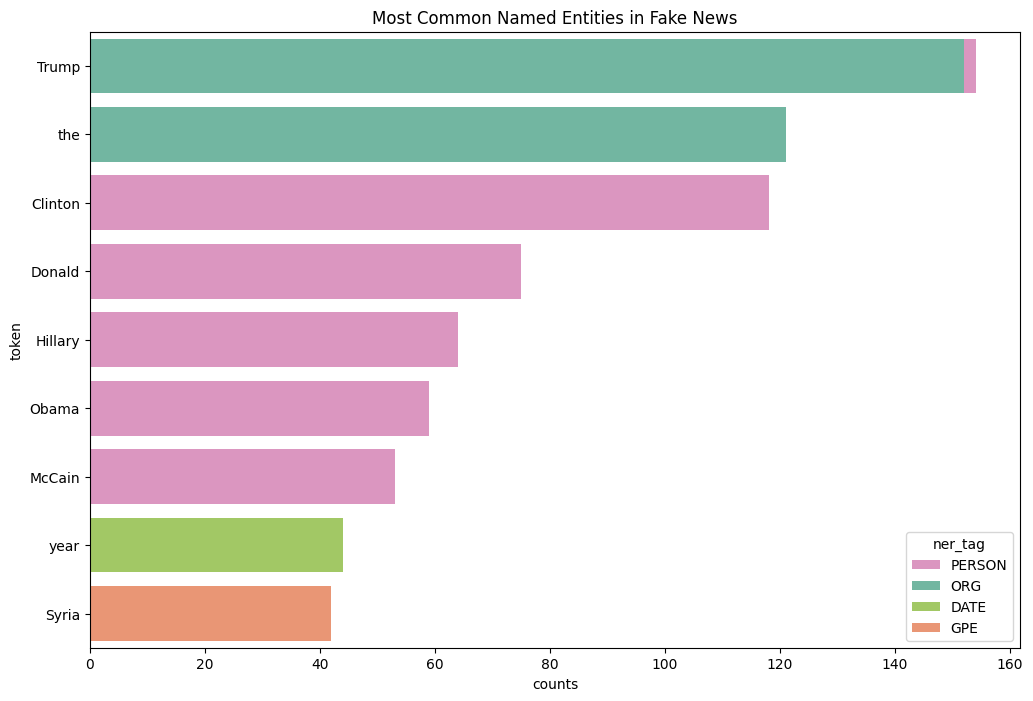

In [106]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_pallete,
    data = top_entities_fake[:10],
    orient = 'h',
    dodge = False
).set(title="Most Common Named Entities in Fake News")

we can see from the graph that most common named entities in fake news are people. This is clearly demonstrated by the colors and the token that are shown. lest check out regarding our factual data news.

[Text(0.5, 1.0, 'Most Common Named Entities in Factual News')]

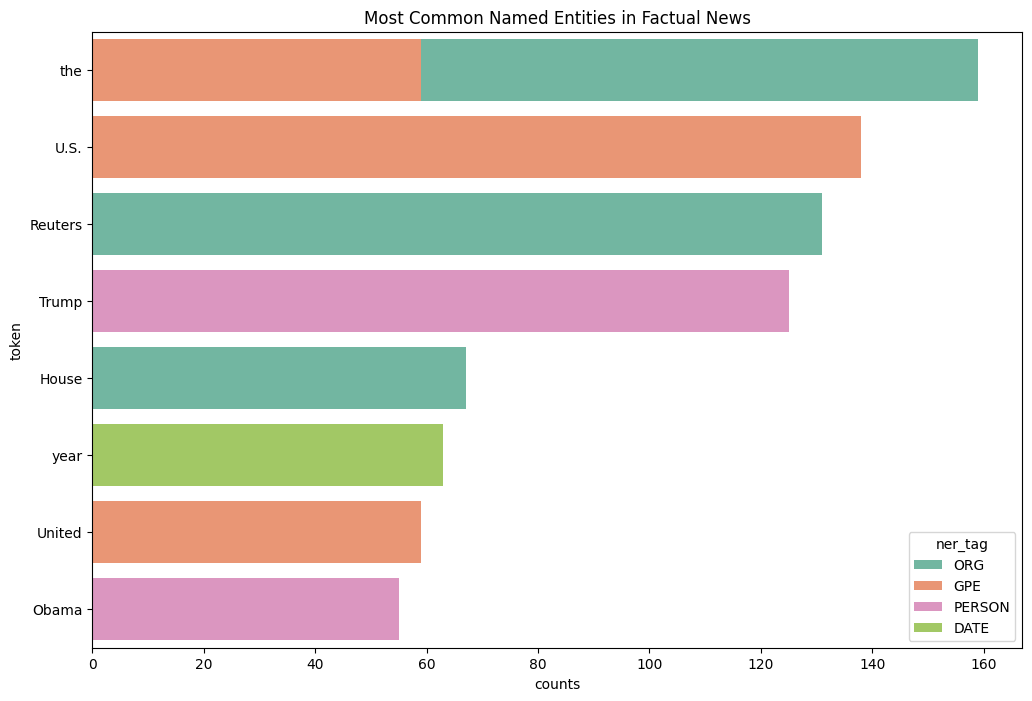

In [107]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_pallete,
    data = top_entities_fact[:10],
    orient = 'h',
    dodge = False
).set(title="Most Common Named Entities in Factual News")

we can see from the graph people are less common in factual news than fake news, Trump and Obara are the only token that appear from top common named entities in factual news data. however, organization and geo-political names seem to be more common. so there's less common named entities for people in factual data.

## Text Pre-processing

In [108]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


Some rows in the text data have a location tag at the start of the text. For example, in the bottom two rows, we  see "Washington" and "Belfast". There's also the router's name followed by a hyphen. We want to clean this up and remove it because it might impact our analysis. We will create a new column called text_clean that will contain all of our cleaned text. We will use data.apply() to apply our re.sub function over the rows in our dataset. Specifically, we will specify a lambda function that uses re.sub with a regular expression to remove everything before and including the first hyphen.

In [109]:
# a lot of the factual news has a location tag at the beginning of the article, let's use regex to remove this
data['text_clean'] = data.apply(lambda x: re.sub(r"^[^-]*-\s","", x['text']), axis=1)

In [110]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,There are two small problems with your analogy...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,Buried in Trump s bonkers interview with New Y...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"Women make up over 50 percent of this country,..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,U.S. Defense Secretary Jim Mattis said on Mond...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,Northern Ireland s political parties are rapid...


the new table  shows that our text_clean column has been added and those location tags have been removed.

In [111]:
# lowercase 
data['text_clean'] = data['text_clean'].str.lower()

In [112]:
# remove punctuation
data['text_clean'] = data.apply(lambda x: re.sub(r"([^\w\s])","", x['text_clean']), axis=1)

In [113]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,there are two small problems with your analogy...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,buried in trump s bonkers interview with new y...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,women make up over 50 percent of this country ...
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,us defense secretary jim mattis said on monday...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,northern ireland s political parties are rapid...


We can see again that the text_clean column has been converted to lowercase and punctuation has been removed.

In [114]:
en_stopwords = stopwords.words('english')
print(en_stopwords) # check this against our most frequent n-grams

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [115]:
# remove punctuation
data['text_clean'] = data['text_clean'].apply(lambda x: " ".join([word for word in x.split() if word not in (en_stopwords)]))

In [116]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,two small problems analogy susan jesus muslim ...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,buried trump bonkers interview new york times ...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,women make 50 percent country grossly underrep...
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,us defense secretary jim mattis said monday ru...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,northern ireland political parties rapidly run...


We can see that the text_clean column shows that stop words have been removed from the text_clean column compared to the original text column.

In [117]:
# tokenize 
data['text_clean'] = data.apply(lambda x: word_tokenize(x['text_clean']), axis=1)

In [120]:
lemmatizer = WordNetLemmatizer()
data['text_clean'] = data['text_clean'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

We use lemmatizing instead of stemming because it is a more intelligent method that preserves much of the context and meaning of words. Since our dataset is not too large, this will not take too long or cause issues later.

In [121]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m..."
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,..."
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon..."
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,..."


we can see from the table that the preprocessing we did confirms that text_clean has been tokenized and lemmatized successfully.

In [122]:
tokens_clean = sum(data['text_clean'], [])

In [132]:
# Analyzing Most Common N-grams After Preprocessing
unigrams = (pd.Series(nltk.ngrams(tokens_clean, 1)).value_counts()).reset_index()[:10]
print(unigrams[:10])

           index  count
0        (said,)    580
1       (trump,)    580
2           (u,)    277
3       (state,)    275
4   (president,)    259
5       (would,)    226
6         (one,)    160
7     (clinton,)    141
8        (year,)    139
9  (republican,)    137


The results are more interesting after preprocessing, as stop words are no longer the most frequent tokens. Instead, meaningful words appear.

C:\Users\ACER\AppData\Local\Temp\ipykernel_19316\318984626.py:3: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='count',


[Text(0.5, 1.0, 'Most Common Unigrams After Preprocessing')]

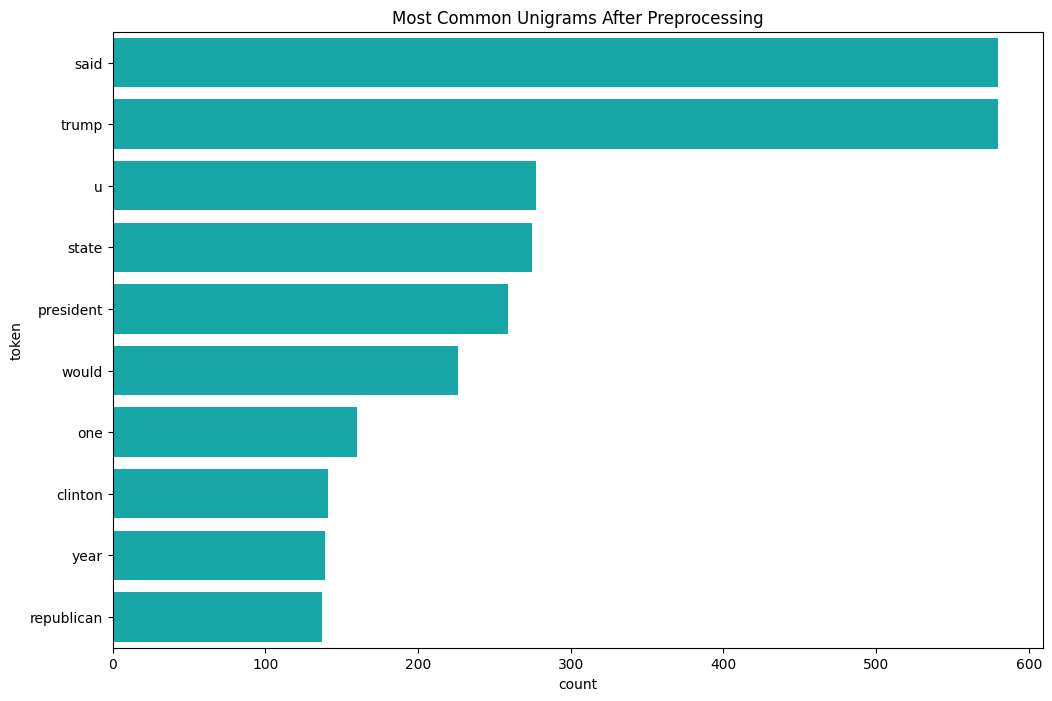

In [133]:
unigrams['token'] = unigrams['index'].apply(lambda x: x[0]) # extract the token from the tuple so we can plot it

sns.barplot(x='count',
           y='token',
           data=unigrams,
           orient='h',
           palette=[default_plot_colour],
           hue='token',
           legend=False)\
.set(title="Most Common Unigrams After Preprocessing")

In [135]:
# Analyzing Most Common N-grams After Preprocessing
bigrams = (pd.Series(nltk.ngrams(tokens_clean, 2)).value_counts()).reset_index()[:10]
print(bigrams[:10])

                     index  count
0          (donald, trump)    113
1          (united, state)     84
2           (white, house)     74
3      (president, donald)     47
4       (hillary, clinton)     39
5              (new, york)     33
6         (supreme, court)     30
7             (image, via)     29
8         (official, said)     26
9  (trump, administration)     26


## Sentiment Analysis

does factual news have a more positive or more negative skewed sentiment compared to the fake news dataset? We will be using the Vader sentiment calculation to perform our sentiment analysis.

In [138]:
# use vader so we also get a neutral sentiment count
vader_sentiment = SentimentIntensityAnalyzer()

In [139]:
data['vader_sentiment_score'] = data['text'].apply(lambda x: vader_sentiment.polarity_scores(x)['compound'])

In [140]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590


In [141]:
# create labels
bins = [-1, -0.1, 0.1, 1]
names= ['negative', 'neutral', 'positive']

In [142]:
data['vader_sentiment_label'] = pd.cut(data['vader_sentiment_score'], bins, labels=names)

In [143]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


Sentiment scores less than -0.1 are classified as negative, scores between -0.1 and 0.1 as neutral, and scores above 0.1 as positive. Now, let's analyze whether sentiment differs between the two types of news articles: fake and factual.

<Axes: xlabel='vader_sentiment_label'>

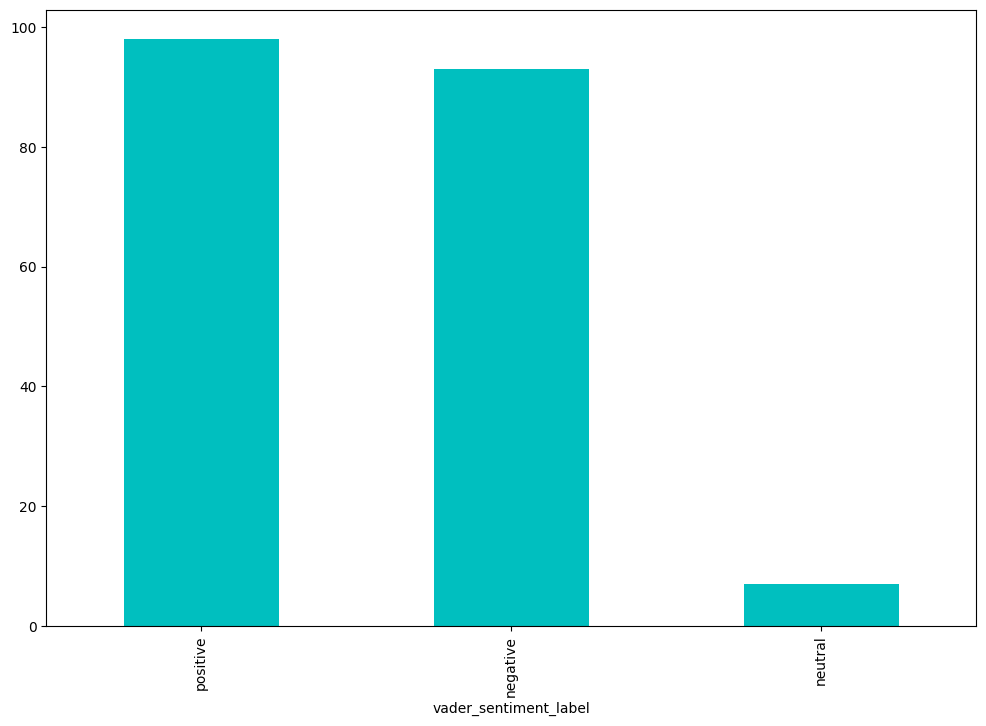

In [144]:
data['vader_sentiment_label'].value_counts().plot.bar(color=default_plot_colour)

From this chart, we observe that there are slightly more news articles with positive sentiment compared to negative sentiment. There are only a few neutral articles.

C:\Users\ACER\AppData\Local\Temp\ipykernel_19316\858597227.py:1: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.countplot(


[Text(0.5, 1.0, 'Sentiment by News Type')]

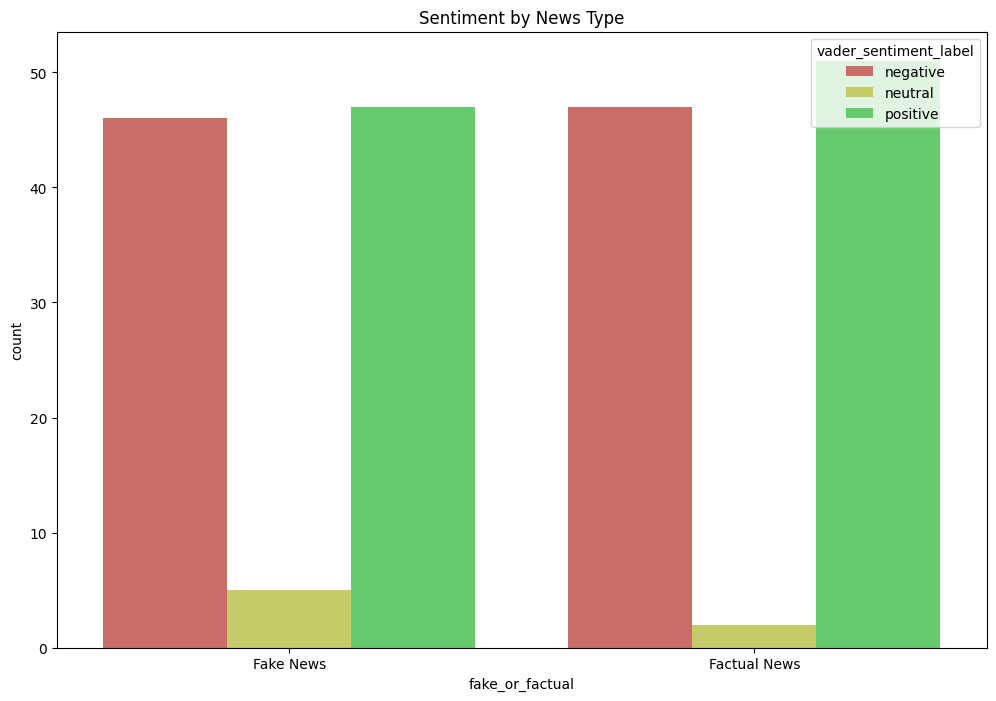

In [145]:
sns.countplot(
    x = 'fake_or_factual',
    hue= 'vader_sentiment_label',
    palette= sns.color_palette("hls"),
    data= data
).set(title = 'Sentiment by News Type')

The plot shows that for fake news, there is a fairly even split between positive and negative sentiment, with a few neutrals. For factual news, positive sentiment skews slightly higher than negative sentiment, and there are fewer neutral articles. Overall, the differences in sentiment distribution between fake and factual news are not drastic. Therefore, it is difficult to conclusively state that factual news skews more positive or that fake news is evenly distributed without further analysis. To deepen this analysis, we could experiment with different sentiment determination methods, such as other rule-based models or pre-trained transformer models.

## Topic Modelling

## LDA

The first step is to vectorize our text, converting it into numerical form that can be fed into the LDA algorithm.

In [146]:
# fake news data vectorization
fake_news_text = data[data['fake_or_factual'] == 'Fake News']['text_clean'].reset_index(drop=True)

Next, we create a dictionary using corpora.Dictionary from the fake news text. This dictionary maps each unique word to an id.

In [147]:
dictionary_fake = corpora.Dictionary(fake_news_text)

In [148]:
doc_term_fake = [dictionary_fake.doc2bow(text) for text in fake_news_text]

In [151]:
# generate coherence scores to determine an optimum number of topics
coherence_values = []
model_list = []

min_topics = 2
max_topics = 11

for num_topics_i in range(min_topics, max_topics+1):
    model = gensim.models.LdaModel(doc_term_fake, num_topics=num_topics_i, id2word = dictionary_fake)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=fake_news_text, dictionary=dictionary_fake, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())

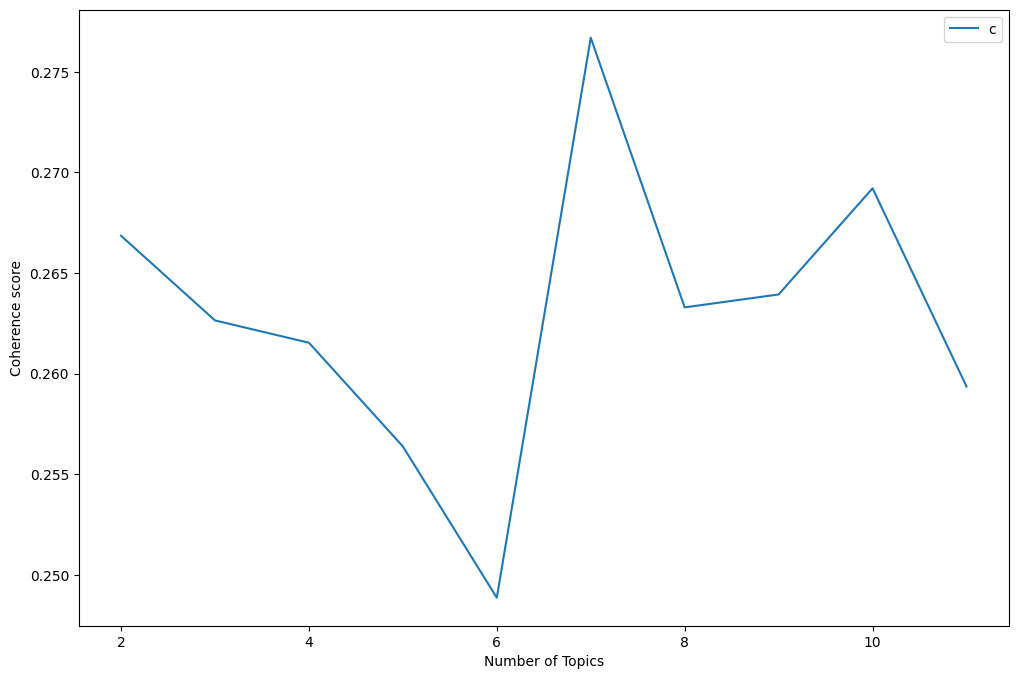

In [152]:
plt.plot(range(min_topics, max_topics+1), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

The coherence scores are highest when the number of topics is set 7. Therefore, we select 7 topics for our final model.

In [153]:
num_topics_lda = 7
lda_model = gensim.models.LdaModel(corpus=doc_term_fake, id2word=dictionary_fake, num_topics=num_topics_lda)

In [154]:
lda_model.print_topics(num_topics= num_topics_lda, num_words=10)

[(0,
  '0.010*"trump" + 0.006*"republican" + 0.005*"clinton" + 0.005*"woman" + 0.005*"president" + 0.004*"one" + 0.004*"would" + 0.004*"hillary" + 0.004*"year" + 0.004*"donald"'),
 (1,
  '0.010*"trump" + 0.006*"said" + 0.006*"state" + 0.004*"clinton" + 0.003*"u" + 0.003*"time" + 0.003*"one" + 0.003*"president" + 0.003*"news" + 0.003*"donald"'),
 (2,
  '0.015*"trump" + 0.006*"state" + 0.005*"said" + 0.005*"president" + 0.004*"would" + 0.004*"u" + 0.003*"know" + 0.003*"one" + 0.003*"clinton" + 0.003*"student"'),
 (3,
  '0.009*"trump" + 0.004*"said" + 0.004*"state" + 0.004*"one" + 0.004*"president" + 0.004*"people" + 0.003*"u" + 0.003*"even" + 0.003*"year" + 0.003*"mccain"'),
 (4,
  '0.013*"trump" + 0.005*"president" + 0.004*"time" + 0.004*"said" + 0.004*"people" + 0.004*"clinton" + 0.004*"republican" + 0.003*"obama" + 0.003*"would" + 0.003*"u"'),
 (5,
  '0.010*"trump" + 0.004*"said" + 0.004*"president" + 0.004*"would" + 0.004*"time" + 0.003*"clinton" + 0.003*"state" + 0.003*"one" + 0.003

Upon examining the topics, we observe considerable overlap. For example, the word "trump" frequently appears across many topics, as does the word "said" and other common words. Therefore, we will explore different techniques to extract more distinct and insightful topics from the data. let's try using latent semantic anaysis with tf-idf vectorization

## TF-IDF & LSA

In [161]:
# create a corpus using tfidf vecotization
def tfidf_corpus(doc_term_matrix):
    tfidf = TfidfModel(corpus= doc_term_matrix, normalize= True)
    corpus_tfidf = tfidf[doc_term_matrix]
    return corpus_tfidf

We define the function tf_IDF_corpus which takes a document term matrix as its argument. Inside, we create the TF-IDF model by passing the corpus (our document term matrix) and setting normalize=True. We then generate the TF-IDF document term matrix and return this corpus.

In [162]:
# generate coherence scores to determine an optimum number of topics
def get_coherence_scores(corpus, dictionary, text, min_topics, max_topics):
    coherence_values = []
    model_list = []
    for num_topics_i in range(min_topics,max_topics+1):
        model = LsiModel(corpus, num_topics= num_topics_i, id2word=dictionary)
        model_list.append(model)
        coherence_model = CoherenceModel(model = model, texts=text, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())

# plot results
    plt.plot(range(min_topics, max_topics+1), coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

In [163]:
corpus_tfidf_fake = tfidf_corpus(doc_term_fake)

We create our TF-IDF corpus for the fake news dataset by calling tf_IDF_corpus with the document term matrix doc_term_fake. Using this corpus, we call get_coherence_scores with the corpus, dictionary dictionary_fake, the fake news text, and specify the minimum number of topics as 2 and the maximum as 11.

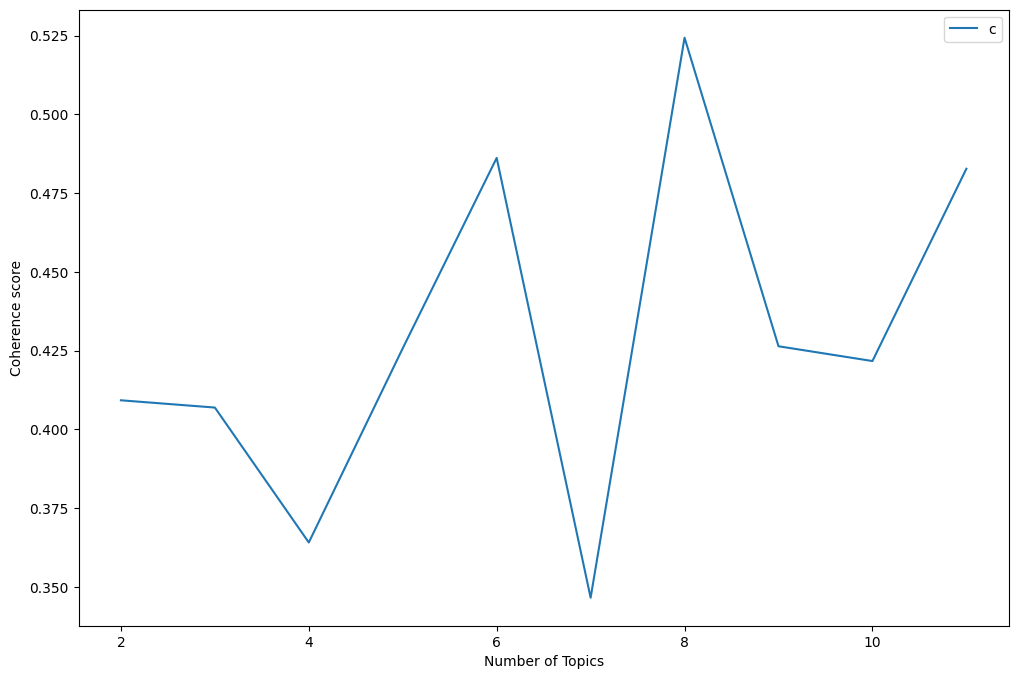

In [167]:
get_coherence_scores(corpus_tfidf_fake, dictionary_fake, fake_news_text, min_topics=2, max_topics=11)

From the coherence scores plot, the optimal number of topics appears to be 8. Therefor, we choose to create our final LSA model with 8 topics.

In [169]:
lsa_model = LsiModel(corpus_tfidf_fake, id2word=dictionary_fake, num_topics=8)

In [170]:
lsa_model.print_topics()

[(0,
  '0.190*"trump" + 0.136*"clinton" + 0.095*"hillary" + 0.094*"obama" + 0.089*"president" + 0.087*"woman" + 0.078*"republican" + 0.077*"party" + 0.077*"flynn" + 0.074*"candidate"'),
 (1,
  '0.325*"boiler" + 0.284*"acr" + 0.244*"room" + 0.240*"pm" + 0.186*"broadcast" + 0.180*"radio" + 0.142*"animal" + 0.142*"tune" + 0.134*"jay" + 0.132*"episode"'),
 (2,
  '-0.623*"flynn" + -0.182*"immunity" + -0.122*"nana" + -0.116*"mr" + -0.110*"30" + -0.108*"march" + -0.102*"russian" + -0.100*"source" + 0.095*"school" + -0.092*"adviser"'),
 (3,
  '0.217*"clinton" + -0.186*"school" + -0.176*"student" + 0.141*"hillary" + -0.121*"county" + -0.121*"flynn" + 0.110*"sander" + 0.098*"debate" + 0.097*"woman" + 0.091*"nominee"'),
 (4,
  '0.200*"email" + -0.194*"trump" + 0.168*"dnc" + -0.142*"flynn" + 0.126*"clinton" + -0.112*"cruz" + 0.111*"department" + 0.110*"rich" + 0.102*"wikileaks" + 0.099*"sander"'),
 (5,
  '-0.276*"student" + -0.160*"conference" + -0.160*"school" + -0.137*"trump" + 0.125*"mccain" + 

The first topic includes words such as Trump, Clinton, and Hillary. The second topic includes boiler, arc, and room. The third topic includes Flynn, immunity, and Nana. These topics show more diversity and interesting themes compared to previous analyses. They provide meaningful insights into the different themes and discussions appearing in fake news.

## Creating our classification model

In [168]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


In [171]:
X = [','.join(map(str, l)) for l in data['text_clean']]
Y = data['fake_or_factual']

In [173]:
# text vectorization - CountVectorizer
countvec = CountVectorizer()
countvec_fit = countvec.fit_transform(X)
bag_of_words = pd.DataFrame(countvec_fit.toarray(), columns = countvec.get_feature_names_out())

In [176]:
# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(bag_of_words, Y, test_size=0.3)

### Logreg

In [181]:
lr = LogisticRegression(random_state=0).fit(X_train, y_train)

In [182]:
y_pred_lr = lr.predict(X_test)

In [183]:
accuracy_score(y_pred_lr, y_test)

0.8166666666666667

The logistic regression model achieves a high accuracy of approximately 82%.

In [192]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

Factual News       0.91      0.80      0.85        40
   Fake News       0.68      0.85      0.76        20

    accuracy                           0.82        60
   macro avg       0.80      0.82      0.80        60
weighted avg       0.84      0.82      0.82        60



Examining the classification report reveals that the model performs pretty good in predicting both fake and factual news. This model alone is quite effective. We optimize for high Fake recall (≥85%) with a precision floor (~≥65%), selecting the threshold by maximizing F2. This catches most fake articles while keeping the review queue manageable.

### SVM

Out of curiosity, we test a support vector machine classifier using the SGDClassifier. We instantiate the model and fit it on the training data.

In [186]:
svm = SGDClassifier().fit(X_train, y_train)

In [187]:
y_pred_svm = svm.predict(X_test)

In [188]:
accuracy_score(y_pred_svm, y_test)

0.8

Evaluating the accuracy of the SVM model shows it performs slightly worse than logistic regression, achieving around 90% accuracy. This highlights the importance of trying simple models first before moving to more complex ones.

In [189]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

Factual News       0.89      0.80      0.84        40
   Fake News       0.67      0.80      0.73        20

    accuracy                           0.80        60
   macro avg       0.78      0.80      0.78        60
weighted avg       0.81      0.80      0.80        60



 classification report for the SVM model confirms it performs fairly well, but not as well as logistic regression.

 Both logistic regression and SVM classifiers work well for this problem, with logistic regression achieving higher accuracy.